# Implementation of the LNMMSB model (static)

In [ ]:

import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy.special import logsumexp
from jax.nn import softmax

from jax import vmap, jit
from jax.tree_util import register_pytree_node_class
from functools import partial

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from models.LNMMSB import jitLNMMSB



In [2]:
from utils.plots import plot_roles

In [3]:
class LNMMSB():
    def __init__(self, nodes, roles, **kwargs):
        self.N = nodes
        self.K = roles

        key = kwargs.get('key', None)
        self.B = kwargs.get('B', None)
        self.mu = kwargs.get('mu', None)
        self.Sigma = kwargs.get('Sigma', None)
        self.gamma_tilde = kwargs.get('gamma_tilde', None)
        self.Sigma_tilde = kwargs.get('Sigma_tilde', None)

        if key is None:
            self.key = jax.random.PRNGKey(0)
        else:
            self.key = jax.random.PRNGKey(key)

        # Initialize model parameters
        if self.B is None:
            self.B = jax.random.uniform(self.key, (self.K, self.K)) # shape (K,K)
        if self.mu is None:
            self.mu = jax.random.multivariate_normal(self.key, jnp.zeros(self.K - 1), jnp.eye(self.K - 1)) # shape (K-1,)
        if self.Sigma is None:
            self.Sigma = jnp.eye(self.K - 1) * 10 #shape (K-1,K-1)

        # self.gamma_tilde = None
        # self.Sigma_tilde = None

        self.EPS = 1e-10  # Or use jnp.finfo(jnp.float32).eps for machine precision

    def expand_gamma(self,gamma_km1):
        '''
        Help function to expand gamma from K-1 to K by appending zeros
        gamma_km1: (N, K-1) 
        returns: (N, K)
        '''
        assert gamma_km1.shape[1] == self.K - 1, "Input gamma must have shape (N, K-1)"
        zeros = jnp.zeros((gamma_km1.shape[0], 1))
        return jnp.concatenate([gamma_km1, zeros], axis=-1)


    def _compute_deltas(self, gamma_tilde, E):
        '''
        Compute delta matrices for all pairs (i,j) given current gamma_tilde and B
        gamma_tilde: (N,K)
        E: adjacency matrix (N,N)
        Returns: delta (N,N,K,K)
        '''
        assert gamma_tilde.shape[1] == self.K, "gamma_tilde must have shape (N, K)"
        gamma_i = gamma_tilde[:, None, :, None] # shape (N,1,K,1)
        gamma_j = gamma_tilde[None, :, None, :] # shape (1,N,1,K)

        gamma_sum = gamma_i + gamma_j # shape (N,N,K,K)

        #print("gamma sum is finite:", jnp.isfinite(gamma_sum).all())
        B_reshaped = self.B[None, None, :, :] # shape (1,1,K,K)
        E_reshaped = E[:, :, None, None] # shape (N,N,1,1)

        log_bernoulli = jnp.where(E_reshaped == 1,
                                jnp.log(B_reshaped + self.EPS),
                                jnp.log1p(-B_reshaped + self.EPS))  # log(1-B) more stable

        delta_exp_term = gamma_sum + log_bernoulli # shape (N,N,K,K)
        #print("delta exp term is finite:", jnp.isfinite(delta_exp_term).all())
        max_delta_exp = jnp.max(delta_exp_term, axis=(-1,-2), keepdims=True)
        delta = jnp.exp(delta_exp_term - (max_delta_exp + logsumexp(delta_exp_term - max_delta_exp, axis=(-1,-2), keepdims=True))) # shape (N,N,K,K) logsumexp trick for numerical stability
        return delta # shape (N,N,K,K)

    def log_likelihood(self, delta, B,  E):
        '''
        Compute log likelihood of data E given current parameters and deltas. Based on eqn (23).
        delta: (N,N,K,K)
        B: (K,K)
        E: adjacency matrix (N,N)
        Returns: scalar log likelihood
        '''
        E_reshaped = E[:, :, None, None] # shape (N,N,1,1)
        B_reshaped = B[None, None, :, :] # shape (1,1,K,K)

        logB = jnp.log(B_reshaped + self.EPS) # shape (1,1,K,K)
        log1mB = jnp.log(1 - B_reshaped + self.EPS) # shape (1,1,K,K)
 
        ll_matrix = E_reshaped * logB + (1 - E_reshaped) * log1mB # shape (N,N,K,K)
        ll = jnp.sum(delta * ll_matrix) # scalar

        return ll
    
    def compute_g_H(self, gamma_hat):
        '''
        Compute g and H at the K-dimensional expansion point gamma_hat.
        gamma_hat: (N, K)
        Returns: g: (N, K), H: (N, K, K)
        '''
        assert gamma_hat.shape[1] == self.K, "gamma_hat must have shape (N, K)"
        
        # The softmax and Hessian formulas are for the K-dimensional vector
        max_gamma = jnp.max(gamma_hat, axis=-1, keepdims=True)
        g = jnp.exp(gamma_hat - (max_gamma + logsumexp(gamma_hat - max_gamma, axis=-1, keepdims=True))) # shape (N,K)
        H = jnp.einsum('ni,ij->nij', g, jnp.eye(self.K)) - jnp.einsum('ni,nj->nij', g, g) # shape (N,K,K)
        
        return g, H
        
    def update_sigma_tilde(self, Sigma_inv, H):
        '''
        Compute Sigma_tilde = (Sigma^{-1} + (2N-2) H_{1:K-1, 1:K-1})^{-1}
        Sigma_inv: (K-1, K-1)
        H: (N, K, K) Hessian from the K-dimensional expansion
        Returns: Sigma_tilde: (N, K-1, K-1)
        '''
        # Take the top-left (K-1, K-1) block of the Hessian
        H_km1 = H[:, :self.K - 1, :self.K - 1] # shape (N, K-1, K-1)
        
        factor = 2.0 * self.N - 2.0
        A = Sigma_inv[None, :, :] + factor * H_km1
        Sigma_tilde = jnp.linalg.inv(A)
        return Sigma_tilde

    def update_gamma_tilde(self, mu, Sigma_tilde, gamma_hat, g, H):
        '''
        Update gamma_tilde using Laplace approximation.

        mu: (K-1,)
        Sigma_tilde: (N, K-1, K-1)
        gamma_hat: (N, K)  
        g: (N, K)        
        H: (N, K, K)      
        Returns: gamma_tilde: (N, K-1)
        '''
        factor = 2.0 * self.N - 2.0
        
        # m_expect is computed over all K roles and must not be truncated.
        m_expect = self.compute_m_expect(self.delta) # shape (N, K)
        
        # Expand mu to K dimensions for the calculation
        mu_expanded = jnp.append(mu, 0.0) # shape (K,)
        
        # The term in brackets from the paper's appendix is K-dimensional
        # It uses all K-dimensional components: m_expect, g, H, gamma_hat, mu_expanded
        term_1_full = (m_expect - factor * g + 
                    factor * jnp.einsum('nij,nj->ni', H, gamma_hat) - 
                    factor * jnp.einsum('nij,j->ni', H, mu_expanded)) # shape (N, K)

        # Truncate the update vector to K-1 dimensions right before the final multiplication
        term_1_km1 = term_1_full[:, :self.K - 1] # shape (N, K-1)

        # Final update is in K-1 dimensional space
        gamma_tilde = mu[None, :] + jnp.einsum('nij,nj->ni', Sigma_tilde, term_1_km1) # shape (N, K-1)

        return gamma_tilde

    def compute_m_expect(self, delta):
        '''
        Compute m_expect per node: m_i,k = sum_{j != i} (E[z_i->j,k] + E[z_i<-j,k])
        delta: (N,N,K,K)
        Returns: m_expect: (N,K)
        '''
        z_ij = jnp.sum(delta, axis=-1) # shape (N,N,K) Expected z_i->j (sender)
        z_ji = jnp.sum(delta, axis=-2) # shape (N,N,K) Expected z_i<-j (receiver)

        z_ij_expected = jnp.sum(z_ij, axis=1) # shape (N,K)
        z_ji_expected = jnp.sum(z_ji, axis=0) # shape (N,K)

        z_sum = z_ij_expected + z_ji_expected# shape (N,K)

        diag_ij = jnp.diagonal(z_ij, axis1=0, axis2=1).T # shape(N,K)
        diag_ji = jnp.diagonal(z_ji, axis1=0, axis2=1).T # shape(N,K)
    
        m_expect = z_sum - diag_ij - diag_ji # shape (N,K)
      

        return m_expect # shape (N,K)
    
    def update_B(self, E, delta):
        '''
        Update B using eq (24): β_{k,l} = sum_{i,j} eij δij(k,l) / sum_{i,j} δij(k,l)
        E: adjacency matrix (N,N)
        delta: (N,N,K,K)
        Returns: updated B (K,K)
        '''
        extended_E = E[:, :, None, None] # shape (N,N,1,1)

        num = jnp.sum(extended_E * delta, axis=(0,1)) # shape (K,K)
        den = jnp.sum(delta, axis=(0,1)) # shape (K,K)

        B_new = jnp.where(den < self.EPS, 
                  0.5 * jnp.ones_like(num),  
                  num / jnp.maximum(den, self.EPS)) # shape (K,K)
        B_new = jnp.clip(B_new, 1e-6, 1 - 1e-6)

        return B_new # shape (K,K)
    
    def update_mu_sigma(self, gamma_tilde, Sigma_tilde):
        '''
        Update mu and Sigma based on eq (13)
        gamma_tilde: (N,K-1)
        Sigma_tilde: (N,K-1,K-1)
        Returns: updated mu (K-1,), updated Sigma (K-1,K-1)
        '''
        mu = jnp.mean(gamma_tilde, axis=0) # shape (K,)

        avg_sigma_tilde = jnp.mean(Sigma_tilde, axis=0)  # shape (K-1,K-1)
        cov_gamma_tilde = jnp.cov(gamma_tilde, rowvar=False)
        # Add small diagonal regularization
        cov_gamma_tilde = cov_gamma_tilde + 1e-8 * jnp.eye(cov_gamma_tilde.shape[0])
        #print('cov gamma tilde is finite:', jnp.isfinite(cov_gamma_tilde).all())
        
        updated_Sigma = avg_sigma_tilde + cov_gamma_tilde # shape (K-1,K-1)
        Sigma = updated_Sigma

        return mu, Sigma

    
    def fit(self, E, max_inner_iters=100, max_outer_iters=100, tol=1e-6, verbose=False):
        '''
        Fit the model to adjacency matrix E using variational EM
        Algorithm described in section 4.2 of the paper
        '''
        i = 0 
        d_ll = jnp.inf
        prev_outer_ll = -jnp.inf
        
        while(d_ll > tol and i < max_outer_iters): # 2 (outer loop)
            if verbose:
                print(f"[outer {i}] mu: {self.mu}, Sigma diag: {jnp.diag(self.Sigma)}, B: {self.B}")

            # E-Step: Inner loop to find optimal q(gamma) and q(z) for fixed mu, Sigma, B
            # -----------------------------------------------------------------------------
            
            # Initialize q(gamma) parameters for the inner loop
            self.gamma_tilde = jax.random.multivariate_normal(self.key, self.mu, self.Sigma, (self.N,)) # shape (N,K-1)
            
            # Pre-calculate Sigma_inv, which is fixed during the inner loop
            jitter = 1e-6 * jnp.eye(self.K-1)
            Sigma_inv = jnp.linalg.inv(self.Sigma + jitter)

            j = 0
            inner_d_ll = jnp.inf
            prev_inner_ll = -jnp.inf
            while(inner_d_ll > tol and j < max_inner_iters): # 2.2 inner loop
                
                # Use gamma_tilde from previous step as the Taylor expansion point
                gamma_hat = self.expand_gamma(self.gamma_tilde)

                # 2.2.1: Update q(z) based on current q(gamma)
                self.delta = self._compute_deltas(gamma_hat, E)

                # 2.2.2: Update q(gamma) based on current q(z)
                g, H = self.compute_g_H(gamma_hat)
                self.Sigma_tilde = self.update_sigma_tilde(Sigma_inv, H)
                self.gamma_tilde = self.update_gamma_tilde(self.mu, self.Sigma_tilde, gamma_hat, g, H)

                # 2.2.3: Update B (part of the M-step, but often updated here for faster convergence)
                self.B = self.update_B(E, self.delta)

                # Convergence check for inner loop
                j += 1
                inner_ll = self.log_likelihood(self.delta, self.B, E) 
                inner_d_ll = jnp.abs(inner_ll - prev_inner_ll)
                prev_inner_ll = inner_ll
                if verbose:
                    print(f"  [inner {j}] ll: {inner_ll:.4f}, d_ll: {inner_d_ll:.6f}")
            # --- End of E-Step ---

            # M-Step: Update mu and Sigma using the converged q(gamma)
            # -------------------------------------------------------------
            self.mu, self.Sigma = self.update_mu_sigma(self.gamma_tilde, self.Sigma_tilde)

            # Convergence check for outer loop
            i += 1
            outer_ll = inner_ll
            d_ll = jnp.abs(outer_ll - prev_outer_ll)
            prev_outer_ll = outer_ll
            print(f"[outer {i}] ll: {outer_ll:.4f}, d_ll: {d_ll:.6f}")
            print(10 * "-", "Params", 10 * "-")
            print(f"mu: {self.mu}")
            print(f"Sigma: {self.Sigma}")
            print(f"B: {self.B}")
            print(30 * "-")

        return outer_ll

    
    def generate_graph(self):
        '''
        Generate a graph from the learned model parameters
        Returns: adjacency matrix (N,N)
        '''
        key, subkey_1, subkey_2, subkey_3, subkey_4 = jax.random.split(self.key, 5)
        # Sample gamma for each node
        if self.gamma_tilde is None:
            print("Sampling new gammas")
            self.gamma_tilde= jax.random.multivariate_normal(subkey_1, self.mu, self.Sigma, (self.N,)) # shape (N,K)
            if(self.gamma_tilde.shape[1] == self.K - 1):
                self.gamma_tilde = self.expand_gamma(self.gamma_tilde)
            pis = softmax(self.gamma_tilde, axis=-1) # shape (N,K)
        else:
            if(self.gamma_tilde.shape[1] == self.K - 1):
                self.gamma_tilde = self.expand_gamma(self.gamma_tilde)
            pis = softmax(self.gamma_tilde, axis=-1)

        #print("pis shape", pis)
        z_ij = jax.random.multinomial(subkey_2, 1, pis, shape=(self.N,self.N,self.K)) # shape (N,N,K)
        #print("z_ij shape", z_ij.shape)
        z_ji = jax.random.multinomial(subkey_3, 1, pis, shape=(self.N, self.N, self.K)) # shape (N,N,K)
        #print("z_ji shape", z_ji.shape)
        
        p = jnp.einsum('ijk, kl -> ijl', z_ij, self.B) # shape (N,N,K)
        #print("p first einsum", p.shape)
        p = jnp.einsum('ijl, jil -> ij', p, z_ji) # shape (N,N)
        #print("p second einsum", p.shape)

        E_sampled = jax.random.bernoulli(subkey_4, p) # shape (N,N)
        return E_sampled
        



## Test

Sampling new gammas


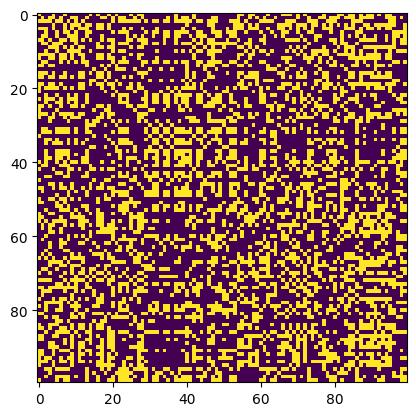

In [4]:
def generate_sbm(sizes, probs):

    assert probs.shape == (len(sizes), len(sizes))

    G = nx.stochastic_block_model(sizes, probs)
    E = nx.to_numpy_array(G)
    gammas = np.zeros((sum(sizes), len(sizes)))

    for i, size in enumerate(sizes):
        gammas[int(np.sum(sizes[:i])):int(np.sum(sizes[:i+1])), i] = 1.0

    return E, gammas

# B  = np.array([[0.3, 0.05, 0.02],
#               [0.05, 0.5, 0.03],
#               [0.02, 0.03, 0.2]])
B = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])
# E, gammas = generate_sbm([50,25,25], B)


# plt.imshow(E)
# plt.show()

#print(gammas)
    
model = LNMMSB(100, 3, key=42, B=B, mu=jnp.array([1,-1,1]), Sigma=jnp.eye(3)*10)
E = model.generate_graph()
true_gammas = model.gamma_tilde
plt.imshow(E)
plt.show()




In [5]:
import time
start = time.time()
model_jit = jitLNMMSB(nodes=100, roles=3, key=10)
model_jit.fit(E, verbose=True, max_inner_iters=1000, max_outer_iters=1000)
end = time.time()
total_jit = end - start
print(f"JIT time {total_jit // 60}m {total_jit % 60:.4f} seconds")

# start = time.time()
# model = LNMMSB(nodes=100, roles=3, key=100)
# model.fit(E, verbose=False, max_inner_iters=1000, max_outer_iters=1000, tol=1e-3)
# end = time.time()
# total_non_jit = end - start
# print(f"Non-JIT time {total_non_jit // 60}m {total_non_jit % 60:.4f} seconds")

# print(f"Acceleration factor {(total_non_jit / total_jit):.2f}x")



JIT time 0.0m 4.7377 seconds d_ll: 0.000001


In [6]:
jnp.set_printoptions(precision=4, suppress=True)

print(model_jit.B)
print(model.B)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1 0 0]
 [0 1 0]
 [0 0 1]]


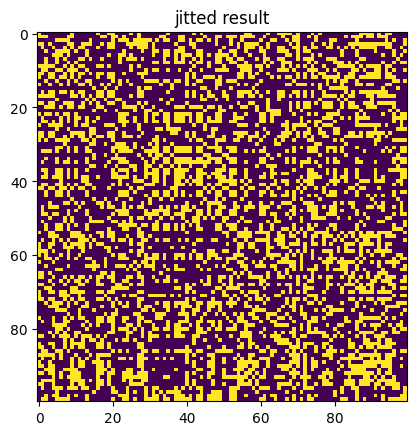

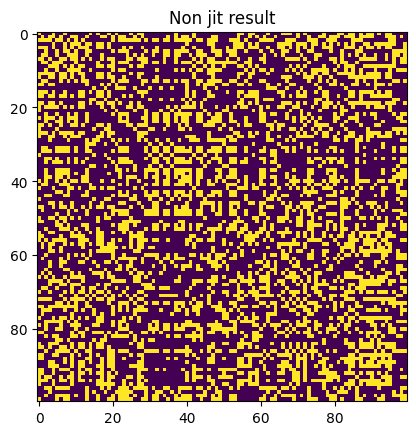

Same result: False


In [7]:

E_sampled_jit = model_jit.generate_graph()
plt.figure()    
plt.title("jitted result")
plt.imshow(E_sampled_jit)
plt.show()

E_sampled = model.generate_graph()
plt.figure()    
plt.title("Non jit result")
plt.imshow(E_sampled)
plt.show()

print("Same result:", jnp.array_equal(E_sampled, E_sampled_jit))

In [8]:
print("Parameters")
print("JIT model parameters")
print(f"B: {model_jit.B}")
print(f"mu: {model_jit.mu}")
print(f"Sigma: {model_jit.Sigma}")
print("Non-JIT model parameters")

Parameters
JIT model parameters
B: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
mu: [1.0852 1.159 ]
Sigma: [[6.0222 1.2215]
 [1.2215 6.2908]]
Non-JIT model parameters


In [9]:
jnp.set_printoptions(precision=2, suppress=True)
print(f"Learned B:\n {model.B}")
print("True B:\n", B)

Learned B:
 [[1 0 0]
 [0 1 0]
 [0 0 1]]
True B:
 [[1 0 0]
 [0 1 0]
 [0 0 1]]


In [10]:
from itertools import permutations
print(list(permutations([0,1,2])))

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


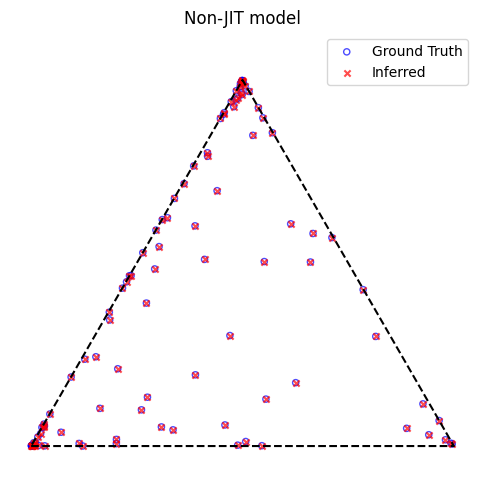

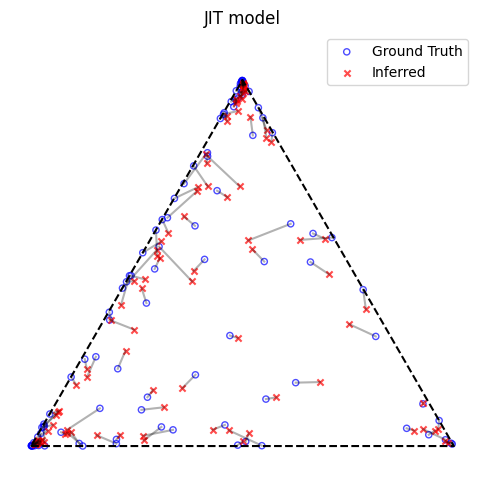

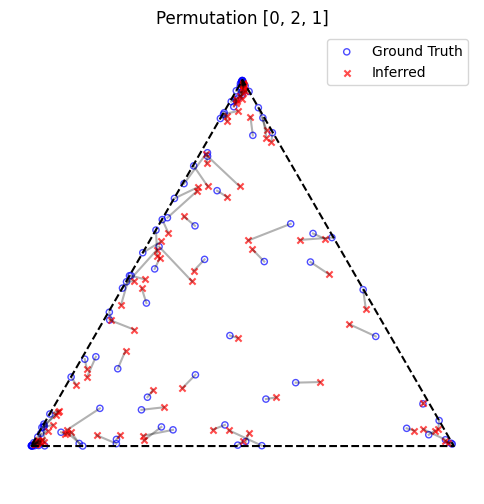

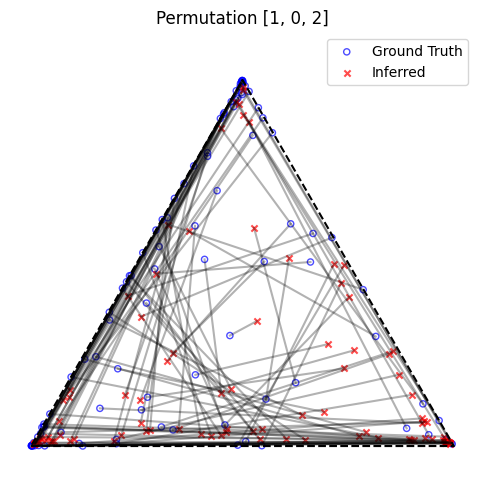

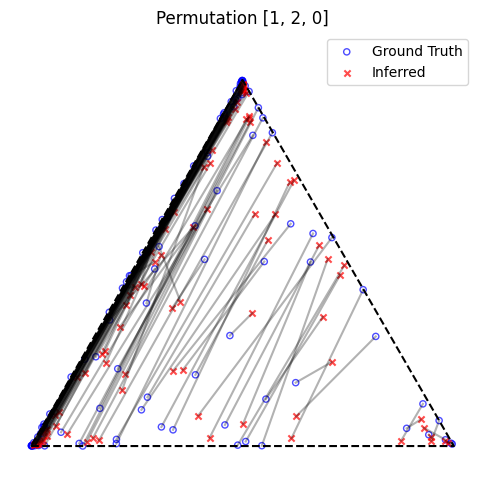

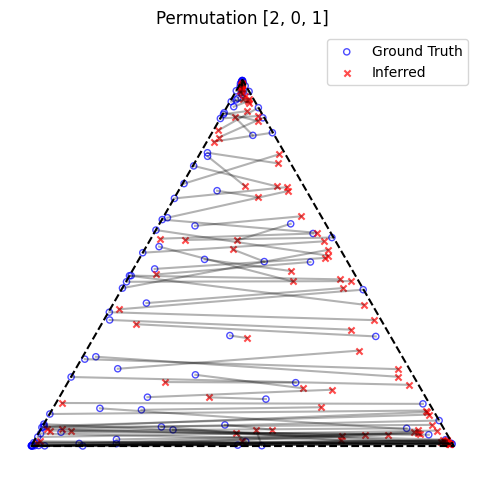

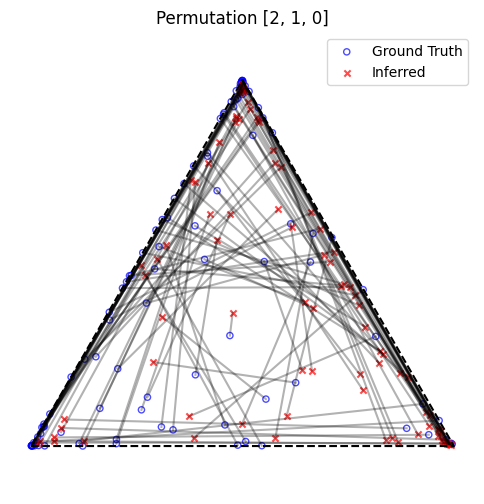

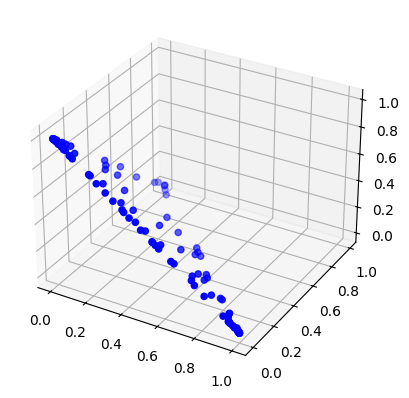

In [11]:
true_pis = jax.nn.softmax(true_gammas, axis=-1)
learned_pis = jax.nn.softmax(model.gamma_tilde, axis=-1)
expanded_gamma_jit = model.expand_gamma(model_jit.gamma_tilde)
jit_pis = jax.nn.softmax(expanded_gamma_jit, axis=-1)


def compute_best_permutation(true_roles, inferred_roles):
    best_perm = None 
    best_loss = jnp.inf
    for perm in permutations(range(true_roles.shape[-1])):
        loss = jnp.mean(jnp.abs(true_roles - inferred_roles[:, perm]))
        if loss < best_loss:
            best_loss = loss
            best_perm = perm
    return best_perm


perm = compute_best_permutation(true_pis, learned_pis)
plot_roles(true_pis, learned_pis[:, perm], title="Non-JIT model")
perm = compute_best_permutation(true_pis, jit_pis)
plot_roles(true_pis, jit_pis[:, perm], title="JIT model")





#permute columns
permutaitons = [
    [0,2,1],
    [1,0,2],
    [1,2,0],
    [2,0,1],
    [2,1,0]
]
for perm in permutaitons:
    plot_roles(true_pis, jit_pis[:,perm], title=f"Permutation {perm}")


import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(true_pis[:,0], true_pis[:,1], true_pis[:,2], c='b', label='True roles')